# Tennischläge klassifizieren - Computer Vision Projekt

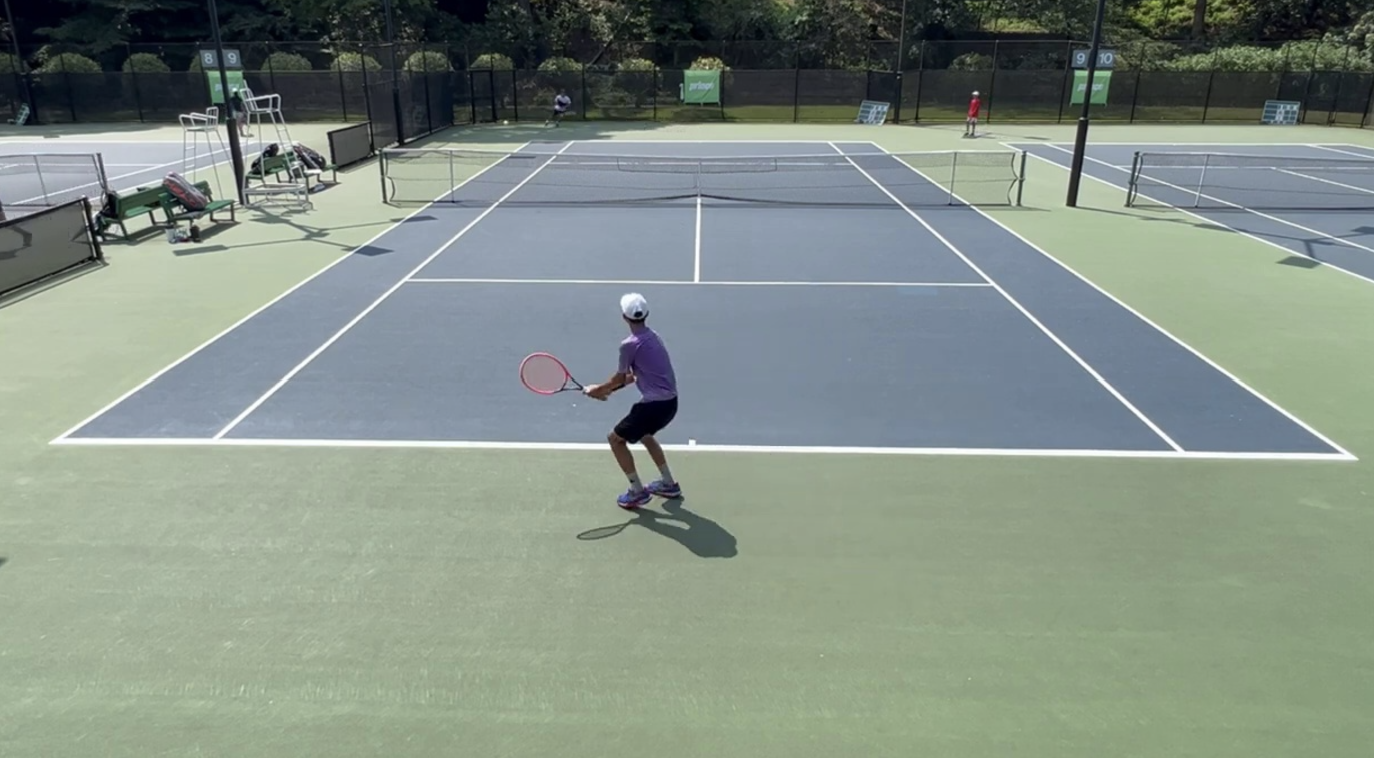

### Beschreibung der Problemstellung

- Entwicklung von einem Modell, welches zwischen den folgennden Tennisshlägen utnerschieden kann: Vorhand, Rückhand und Aufschlag
- Klassifierungsaufgabe wobei ein Model Muster erkennen kann und auch neue Daten von einem anderen Datensatz erkennen soll.
- Hierbei wird ein Datensatz genommen umd das Model zu tranieren und valideren, und einen neues Datensatz mit selbs erhobenen Daten, um dieses zu testen..
-  Es werden verschiedene Modele wie Resnet 18 angewendet.
- Das Zielist eine möglichst hohe accuray zu erreichn und gleichzeit overfitting zu veremdien.


### Datensätze

- **Traindatensatz**: [Motion Analysis of Tennis Strokes Using Pose Estimation](https://www.sciencedirect.com/science/article/pii/S2352340924006322)
- **Testdatensatz**: Selbst erhoben

### Bilder vorbereiten - cropping

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Get the current working directory
base_path = os.getcwd()

# Define the relative path to the folder containing the categories
parent_folder_path = "/teamspace/studios/this_studio/final_folder_testing/original_pictures"

# Define the categories
categories = ["forehand", "backhand", "serve"]

# Function to display an image from each category
def show_images_from_categories(base_path, categories, parent_folder_path):
    fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))
    
    for ax, category in zip(axes, categories):
        category_path = os.path.join(parent_folder_path, category)
        
        # Ensure the folder exists
        if not os.path.exists(category_path):
            ax.set_title(f"Folder '{category}' is missing")
            ax.axis("off")
            continue
        
        # Select an image from the category
        image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        
        if image_files:
            # Select the first image
            image_path = os.path.join(category_path, image_files[0])
            img = Image.open(image_path)
            
            ax.imshow(img)
            ax.set_title(category)
            ax.axis("off")
        else:
            ax.set_title(f"No images in '{category}'")
            ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Display images
show_images_from_categories(base_path, categories, parent_folder_path)


### Rolle von YOLO im Skript

Dieses Skript verwendet YOLOv5, um **Personen** in Tennisbildern zu erkennen, indem es Begrenzungsrahmen um die Spieler identifiziert. Die erkannten Begrenzungsrahmen werden mit einem Rand zugeschnitten, auf eine einheitliche Zielgröße skaliert und in einem neuen Verzeichnis gespeichert, wobei die ursprüngliche Ordnerstruktur beibehalten wird.



In [ ]:
import torch
from pathlib import Path
from PIL import Image
import os

# Load the YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

def crop_and_resize_image(image_path: str, output_folder: str, base_folder: str, margin=0.5, target_size=(224, 224)):
    try:
        # Derive the relative path to retain folder structure
        relative_path = Path(image_path).relative_to(base_folder)  # e.g., backhand/B_001.jpeg
        new_file_path = Path(output_folder) / relative_path  # e.g., cropped_original/original_pictures/backhand/B_001.jpeg

        # Skip if the file already exists
        if new_file_path.exists():
            print(f"Skipping {new_file_path}, already exists.")
            return True

        # Load the image
        image = Image.open(image_path)
        results = model(image_path)  # Run YOLO detection on the image

        # Filter detections for 'person' class
        person_detections = [det for det in results.xyxy[0].tolist() if int(det[5]) == 0]  # Class '0' is 'person'

        if not person_detections:
            print(f"No person detected in {image_path}")
            return False

        # Find the largest bounding box for the closest person
        closest_person = max(person_detections, key=lambda det: (det[2] - det[0]) * (det[3] - det[1]))

        # Extract bounding box coordinates
        xmin, ymin, xmax, ymax = map(int, closest_person[:4])

        # Calculate margin for consistent cropping
        img_width, img_height = image.size
        box_width = xmax - xmin
        box_height = ymax - ymin

        # Apply the margin to create a similar crop
        xmin = max(0, xmin - int(box_width * margin))
        ymin = max(0, ymin - int(box_height * margin))
        xmax = min(img_width, xmax + int(box_width * margin))
        ymax = min(img_height, ymax + int(box_height * margin))

        # Crop the image around the player
        cropped_image = image.crop((xmin, ymin, xmax, ymax))

        # Resize to a fixed target size for consistency
        resized_image = cropped_image.resize(target_size)

        # Ensure the output folder exists
        new_file_path.parent.mkdir(parents=True, exist_ok=True)

        # Save the resized and cropped image
        resized_image.save(new_file_path)
        print(f"Saved cropped and resized image to {new_file_path}")
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return False
    return True

# Define paths for the dataset (relative paths)
datasets = {
    "original_pictures": "/teamspace/studios/this_studio/final_folder_testing/original_pictures",  # Full path
}

# Output base path (new folder: cropped_original)
output_base_path = "/teamspace/studios/this_studio/final_folder_testing/cropped_original_pictures"  # Specify the new folder here

# Process each dataset with consistent cropping and resizing
failed_paths = []
for dataset_name, dataset_path in datasets.items():
    # Get all image files recursively within the current directory
    all_file_paths = list(Path(dataset_path).rglob("*.jpeg"))  # Get all JPEG files recursively

    # Specify the correct output subpath (relative path)
    dataset_output_path = Path(output_base_path) / dataset_name  # e.g., cropped_original/original_pictures

    for file_path in all_file_paths:
        success = crop_and_resize_image(
            image_path=file_path.as_posix(),
            output_folder=dataset_output_path.as_posix(),
            base_folder=dataset_path,
            margin=0.5,
            target_size=(500, 500)
        )
        if not success:
            failed_paths.append(file_path)

# Output any failed images
if failed_paths:
    print("Failed Images:")
    for failed_path in failed_paths:
        print(failed_path)


### Visualisierung von Beispieldaten

Dieser Code lädt ein Beispielbild aus jeder Kategorie (`backhand`, `forehand`, `serve`) und zeigt es in einem Diagramm an. Ziel ist es, die Struktur und Qualität der Daten zu überprüfen, bevor mit der Verarbeitung begonnen wird.

In [ ]:
# Add this at the top of your notebook
%matplotlib inline


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define paths and categories
base_path = '/teamspace/studios/this_studio/final_folder/cropped/original_pictures'
categories = ['backhand', 'forehand', 'serve']

# Visualize a few samples from each category
def visualize_samples(base_path, categories):
    fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))
    for i, category in enumerate(categories):
        folder_path = os.path.join(base_path, category)
        sample_image = os.listdir(folder_path)[0]  # Take the first image from each category
        img_path = os.path.join(folder_path, sample_image)
        image = Image.open(img_path)
        axes[i].imshow(image)
        axes[i].set_title(category)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

visualize_samples(base_path, categories)

## Vorverarbeitung und Aufteilung

Die Bilder werden skaliert, normalisiert und in Tensoren umgewandelt. Anschließend wird der Datensatz stratifiziert in Trainings-, Validierungs- und Testsätze aufgeteilt, um ein ausgewogenes Verhältnis der Klassen zu gewährleisten.

In [ ]:
from sklearn.model_selection import train_test_split
from torchvision import transforms

# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load all image paths and labels
image_paths = []
labels = []
category_to_label = {category: idx for idx, category in enumerate(categories)}

for category in categories:
    folder_path = os.path.join(base_path, category)
    for file in os.listdir(folder_path):
        if file.endswith('.jpeg'):
            image_paths.append(os.path.join(folder_path, file))
            labels.append(category_to_label[category])

# Split data into train, validation, and test
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

print(f"Train size: {len(train_paths)}, Validation size: {len(val_paths)}, Test size: {len(test_paths)}")


### Datensatz-Erstellung und Visualisierung

Ein benutzerdefiniertes Dataset wird erstellt, das Bildpfade und Labels enthält und optional Transformationen anwendet. Anschließend werden einige Beispiele aus dem Trainingsdatensatz visualisiert, um die Anwendung der Transformationen und die Zuordnung der Labels zu überprüfen.


In [ ]:
from torch.utils.data import Dataset
import torch

class TennisDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Visualize transformed images
def visualize_transformed_images(dataset, categories):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        image, label = dataset[i]
        axes[i].imshow(image.permute(1, 2, 0))  # Convert CHW to HWC
        axes[i].set_title(categories[label])
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

train_dataset = TennisDataset(train_paths, train_labels, transform)
visualize_transformed_images(train_dataset, categories)


### Modellaufbau

Ein vortrainiertes ResNet-18-Modell wird verwendet, um die Klassifikation der Tennisschläge durchzuführen. Die letzte Schicht des Modells wird angepasst, um die Zielklassen (`forehand`, `backhand`, `serve`) zu unterstützen. 

Zusätzlich wird der Datensatz in Trainings-, Validierungs- und Testsätze unterteilt, und die entsprechenden `DataLoader` werden erstellt, um die Daten während des Trainings, der Validierung und des Testens bereitzustellen.

Das Modell verwendet:
- **Loss-Funktion**: `CrossEntropyLoss`, geeignet für mehrklassige Klassifikationsaufgaben.
- **Optimierer**: `Adam`, mit einer Lernrate von 0.001 für effizientes Training.
- **Testsatz**: Ermöglicht die abschließende Bewertung des Modells auf ungesehenen Daten.


In [ ]:
from torchvision import models
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Step 1: Define the model, loss function, and optimizer
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(categories))  # Adjust output layer for categories
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 2: Split data into train, validation, and test sets
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# Step 3: Create datasets
train_dataset = TennisDataset(train_paths, train_labels, transform)
val_dataset = TennisDataset(val_paths, val_labels, transform)
test_dataset = TennisDataset(test_paths, test_labels, transform)  # Added test dataset

# Step 4: Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Added test DataLoader

print("Model, datasets, and DataLoaders initialized successfully!")




### Training des Modells

Das Modell wird über mehrere Epochen trainiert. In jeder Epoche werden Verlust und Genauigkeit für die Trainings- und Validierungsdaten berechnet und aufgezeichnet. Die Ergebnisse zeigen die Modellleistung und helfen, den Trainingsfortschritt zu überwachen.

In [ ]:
# Initialize lists to store metrics
train_loss = []
val_loss = []
train_acc = []
val_acc = []

epochs = 10
early_stop_patience = 3  # Stop after 3 consecutive epochs without improvement
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Store training metrics
    train_loss.append(running_loss / len(train_loader))
    train_acc.append(100 * correct_train / total_train)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Store validation metrics
    val_loss.append(running_val_loss / len(val_loader))
    val_acc.append(100 * correct_val / total_val)

    # Check for early stopping
    if val_loss[-1] < best_val_loss:
        best_val_loss = val_loss[-1]
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    # Print metrics for the epoch
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%")
    print(f"Validation Loss: {val_loss[-1]:.4f}, Validation Accuracy: {val_acc[-1]:.2f}%")


In [ ]:
# Save the trained model
model_save_path = "/teamspace/studios/this_studio/final_folder_testing/trained_tennis_model.pth"  # Hardcoded path
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


### Modellbewertung

Das Modell wird mit Testdaten überprüft, um seine Leistung auf neuen, ungesehenen Daten zu beurteilen. Die Ergebnisse werden anhand von Metriken wie Genauigkeit und einer Konfusionsmatrix dargestellt, um die Qualität der Klassifikationen zu bewerten.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Test evaluation
model.eval()
test_labels = []
test_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:  # Use test_loader here
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_labels.extend(labels.numpy())
        test_preds.extend(predicted.numpy())

# Calculate test accuracy
correct = sum([1 for true, pred in zip(test_labels, test_preds) if true == pred])
total = len(test_labels)
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Confusion matrix for test set
test_cm = confusion_matrix(test_labels, test_preds)

# Heatmap with blue-red colormap
sns.heatmap(test_cm, annot=True, fmt="d", xticklabels=categories, yticklabels=categories, cmap="coolwarm")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Confusion Matrix")
plt.show()

# Classification report for test set
print("Test Set Classification Report")
print(classification_report(test_labels, test_preds, target_names=categories))



## Hinzufügen von weiteren Daten

Dieser Code extrahiert Frames aus den angegebenen Video-Dateien (`backhand.MOV`, `forehand.MOV`, `serve.MOV`) und speichert sie in entsprechenden Ordnern innerhalb des `new_data`-Verzeichnisses. Die Frames werden in regelmäßigen Abständen (alle 8 Frames) gespeichert und dabei die ursprüngliche Ordnerstruktur beibehalten.


In [ ]:
import os
import cv2
from pathlib import Path

# Absolute paths to video files
video_paths = {
    'backhand.MOV': '/teamspace/studios/this_studio/final_folder_testing/backhand.MOV',
    'forehand.MOV': '/teamspace/studios/this_studio/final_folder_testing/forehand.MOV',
    'serve.MOV': '/teamspace/studios/this_studio/final_folder_testing/serve.MOV'
}

# Base path for the new data folder (relative to the notebook directory or absolute URL path)
new_data_base_path = '/teamspace/studios/this_studio/final_folder_testing/new_data'

# Create directories to save frames in the new_data folder
output_folders = {
    'backhand_frames': Path(new_data_base_path) / 'backhand_frames',
    'forehand_frames': Path(new_data_base_path) / 'forehand_frames',
    'serve_frames': Path(new_data_base_path) / 'serve_frames'
}

# Create the directories if they don't exist
for folder in output_folders.values():
    os.makedirs(folder, exist_ok=True)

# Function to extract frames from a video
def extract_frames(video_path, output_folder, frame_interval=8):
    if not os.path.exists(video_path):
        print(f"Error: Video file {video_path} does not exist.")
        return

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_path}.")
        return

    frame_count = 0
    saved_frame_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Save frames at specific intervals
        if frame_count % frame_interval == 0:
            frame_filename = output_folder / f'frame_{saved_frame_count:04d}.jpg'
            
            # Skip saving if the file already exists
            if frame_filename.exists():
                print(f"Skipping {frame_filename}, already exists.")
            else:
                cv2.imwrite(str(frame_filename), frame)
                saved_frame_count += 1
        
        frame_count += 1
    
    cap.release()
    print(f'Extracted {saved_frame_count} new frames from {video_path}')

# Extract frames for each video
for video_name, video_path in video_paths.items():
    output_folder = output_folders[video_name.split('.')[0] + '_frames']
    print(f"Processing {video_name}...")
    extract_frames(video_path, output_folder)

print("Frame extraction completed. Frames are stored in 'new_data'.")


Das Skript verarbeitet Videoaufnahmen für verschiedene Tennisschlagarten (Vorhand, Rückhand, Aufschlag), indem es bestimmte Sequenzen von Bildern in die entsprechenden Verzeichnisse kopiert. Es verwendet relative Pfade, liest Indexdateien, um die zu extrahierenden Bilder zu bestimmen, und protokolliert den Fortschritt, während sichergestellt wird, dass die Zielverzeichnisse erstellt werden, falls sie nicht existieren.



In [ ]:
import os
import shutil
from pathlib import Path
import logging
from logging import StreamHandler

# Configure logging
log_level = logging.INFO
logger = logging.getLogger(__name__)
logger.setLevel(log_level)
logging_formatter = logging.Formatter(fmt="%(asctime)s %(levelname)-8s %(name)-15s %(message)s",
                                      datefmt="%Y-%m-%d %H:%M:%S")
stream_handler = StreamHandler()
stream_handler.setLevel(logging.DEBUG)
stream_handler.setFormatter(logging_formatter)
logger.addHandler(stream_handler)

####################### INPUT DEFINITIONS ##############################################################################
# Base folder paths (updated to the new directory)
base_folder = Path("/teamspace/studios/this_studio/final_folder_testing")
image_source_paths = {
    "forehand": base_folder.joinpath("new_data/forehand_frames"),
    "backhand": base_folder.joinpath("new_data/backhand_frames"),
    "serve": base_folder.joinpath("new_data/serve_frames")
}
image_target_path = base_folder.joinpath("processed_images")
index_file_map = {
    "forehand": base_folder.joinpath("F_indexes.txt"),
    "backhand": base_folder.joinpath("B_indexes.txt"),
    "serve": base_folder.joinpath("S_indexes.txt"),
}

# General settings
num_files_per_sequence = 5

##################### END INPUT DEFINITIONS ############################################################################

# Main logic for processing all hit types
logger.info("Start script")
try:
    for hit_type, source_path in image_source_paths.items():
        # Validate hit_type
        if hit_type not in index_file_map:
            logger.warning(f"No index file found for {hit_type}. Skipping...")
            continue

        # File prefix based on hit_type
        file_prefix = hit_type[0].upper()

        # Load indexes
        index_file_path = index_file_map[hit_type]
        if not index_file_path.exists():
            logger.warning(f"Index file {index_file_path} does not exist. Skipping {hit_type}...")
            continue

        with open(index_file_path, "r") as f:
            lines = f.readlines()
            indexes = [int(x.strip("\n")) for x in lines if len(x.strip("\n")) > 0]

        # Ensure the target directory exists
        target_path = image_target_path.joinpath(hit_type)
        os.makedirs(target_path, exist_ok=True)

        # Process frames
        for sequence_index, file_index in enumerate(indexes):
            for seq_file_index, i in enumerate(range(file_index - num_files_per_sequence + 1, file_index + 1)):
                # Adjusted to match your filename pattern (e.g., frame_XXXX.jpg)
                source_file = source_path.joinpath(f"frame_{i:04}.jpg")
                target_file = target_path.joinpath(f"{file_prefix}_{sequence_index:03}_{seq_file_index:03}.jpeg")

                if source_file.exists():
                    shutil.copyfile(source_file, target_file)
                    logger.info(f"Copied {source_file} to {target_file}")
                else:
                    logger.warning(f"Source file {source_file} does not exist and was skipped.")

        logger.info(f"Finished processing {hit_type}. {len(indexes)} sequences copied to {target_path}")

except Exception as e:
    logger.exception("Exception occurred", exc_info=True)
finally:
    logger.info("Script completed.")


Dieser Code visualisiert eine Sequenz von 5 Bildern aus einem bestimmten Ordner, die anhand eines definierten Präfixes (z. B. `F_000` für Vorhand) ausgewählt werden. Die Bilder werden nebeneinander dargestellt, um eine visuelle Überprüfung der Sequenz in der Kategorie (z. B. Vorhand, Rückhand oder Aufschlag) zu ermöglichen.


In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path

# Function to visualize a sequence of 5 images
def visualize_sequence(sequence_folder, sequence_prefix, num_images=5):
    images = sorted(sequence_folder.glob(f"{sequence_prefix}_*.jpeg"))
    if len(images) < num_images:
        print(f"Not enough images in {sequence_folder} for sequence {sequence_prefix}")
        return

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, image_path in enumerate(images[:num_images]):
        img = plt.imread(image_path)
        axes[i].imshow(img)
        axes[i].set_title(image_path.name)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage with relative paths based on current working directory
current_dir = Path.cwd()  # Assuming script is running from the base folder location
processed_folder = current_dir / "final_folder_testing/processed_images"  # Updated path
hit_type = "forehand"  # Change to "backhand" or "serve" as needed
sequence_folder = processed_folder / hit_type  # Path to the folder containing sequences
sequence_prefix = "F_000"  # Adjust the prefix to match a specific sequence

# Display the first sequence
visualize_sequence(sequence_folder, sequence_prefix)


### Nächster Schritt

Dieses Skript schneidet Personen aus Bildern mit Hilfe von YOLOv5, indem es die größten Bounding Boxes für die Klasse "Person" erkennt, und speichert die zugeschnittenen und auf eine einheitliche Größe skalierten Bilder in einem neuen Ordner. Im nächsten Schritt können die verarbeiteten Bilder verwendet werden, um Trainings- oder Testdatensätze für das Modell zu erstellen und weiterzuverarbeiten.


In [ ]:
import torch
from pathlib import Path
from PIL import Image
import os

# Load the YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

def crop_and_resize_image(image_path: str, output_folder: str, base_folder: str, margin=0.5, target_size=(224, 224)):
    try:
        # Derive the relative path to retain folder structure
        relative_path = Path(image_path).relative_to(base_folder)  # e.g., backhand/B_001.jpeg
        new_file_path = Path(output_folder) / relative_path  # e.g., cropped_original/original_pictures/backhand/B_001.jpeg

        # Skip if the file already exists
        if new_file_path.exists():
            print(f"Skipping {new_file_path}, already exists.")
            return True

        # Load the image
        image = Image.open(image_path)
        results = model(image_path)  # Run YOLO detection on the image

        # Filter detections for 'person' class
        person_detections = [det for det in results.xyxy[0].tolist() if int(det[5]) == 0]  # Class '0' is 'person'

        if not person_detections:
            print(f"No person detected in {image_path}")
            return False

        # Find the largest bounding box for the closest person
        closest_person = max(person_detections, key=lambda det: (det[2] - det[0]) * (det[3] - det[1]))

        # Extract bounding box coordinates
        xmin, ymin, xmax, ymax = map(int, closest_person[:4])

        # Calculate margin for consistent cropping
        img_width, img_height = image.size
        box_width = xmax - xmin
        box_height = ymax - ymin

        # Apply the margin to create a similar crop
        xmin = max(0, xmin - int(box_width * margin))
        ymin = max(0, ymin - int(box_height * margin))
        xmax = min(img_width, xmax + int(box_width * margin))
        ymax = min(img_height, ymax + int(box_height * margin))

        # Crop the image around the player
        cropped_image = image.crop((xmin, ymin, xmax, ymax))

        # Resize to a fixed target size for consistency
        resized_image = cropped_image.resize(target_size)

        # Ensure the output folder exists
        new_file_path.parent.mkdir(parents=True, exist_ok=True)

        # Save the resized and cropped image
        resized_image.save(new_file_path)
        print(f"Saved cropped and resized image to {new_file_path}")
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return False
    return True

# Define paths for the dataset (relative paths)
datasets = {
    "original_pictures": "/teamspace/studios/this_studio/final_folder_testing/processed_images",  # Full path
}

# Output base path (new folder: cropped_original)
output_base_path = "/teamspace/studios/this_studio/final_folder_testing/cropped_processed"  # Specify the new folder here

# Process each dataset with consistent cropping and resizing
failed_paths = []
for dataset_name, dataset_path in datasets.items():
    # Get all image files recursively within the current directory
    all_file_paths = list(Path(dataset_path).rglob("*.jpeg"))  # Get all JPEG files recursively

    # Specify the correct output subpath (relative path)
    dataset_output_path = Path(output_base_path) / dataset_name  # e.g., cropped_original/original_pictures

    for file_path in all_file_paths:
        success = crop_and_resize_image(
            image_path=file_path.as_posix(),
            output_folder=dataset_output_path.as_posix(),
            base_folder=dataset_path,
            margin=0.5,
            target_size=(500, 500)
        )
        if not success:
            failed_paths.append(file_path)

# Output any failed images
if failed_paths:
    print("Failed Images:")
    for failed_path in failed_paths:
        print(failed_path)



In [ ]:
import os
from pathlib import Path
import shutil

# Pfad zum aktuellen Verzeichnis mit 'original_pictures'
source_base_path = Path("/teamspace/studios/this_studio/final_folder_testing/cropped_processed/original_pictures")

# Neuer Basispfad ohne 'original_pictures'
target_base_path = Path("/teamspace/studios/this_studio/final_folder_testing/cropped_processed")

# Alle Kategorien (Ordner wie 'backhand', 'forehand', 'serve')
categories = ["backhand", "forehand", "serve"]

# Bilder verschieben
if source_base_path.exists():
    for category in categories:
        source_path = source_base_path / category
        target_path = target_base_path / category

        # Skip if source path does not exist
        if not source_path.exists():
            print(f"Source folder does not exist: {source_path}. Skipping...")
            continue

        # Zielordner erstellen, falls nicht vorhanden
        os.makedirs(target_path, exist_ok=True)

        # Alle Dateien im Quellordner verschieben
        for file in source_path.iterdir():
            if file.is_file() and file.suffix.lower() in [".jpeg", ".jpg", ".png"]:  # Nur Bilddateien verschieben
                target_file = target_path / file.name
                shutil.move(str(file), str(target_file))  # Datei verschieben
                print(f"Moved {file} to {target_file}")

    # Optional: Leere Verzeichnisse entfernen
    for category in categories:
        source_path = source_base_path / category
        if source_path.exists() and not any(source_path.iterdir()):
            source_path.rmdir()
            print(f"Removed empty folder: {source_path}")

    print("All files have been moved.")
else:
    print(f"Source base path does not exist: {source_base_path}. Nothing to do.")


## Testing the model on the second dataset

#### Mit Resnet 18

In [ ]:
import os
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# Define the second dataset's base path
second_dataset_path = "/teamspace/studios/this_studio/final_folder_testing/cropped_processed"

# Categories and label mapping
categories = ['forehand', 'backhand', 'serve']
category_to_label = {category: idx for idx, category in enumerate(categories)}

# Load all image paths and labels from the second dataset
image_paths = []
labels = []

for category in categories:
    folder_path = Path(second_dataset_path) / category
    if not folder_path.exists():
        print(f"Warning: {folder_path} does not exist. Skipping category {category}.")
        continue
    for file in folder_path.glob("*.jpeg"):  # Match JPEG files
        image_paths.append(str(file))
        labels.append(category_to_label[category])

# Define the custom dataset class
class TennisDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations for the second dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Match the input size expected by the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Same normalization as during training
])

# Create the second dataset and DataLoader
second_dataset = TennisDataset(image_paths, labels, transform)
second_loader = DataLoader(second_dataset, batch_size=32, shuffle=False)

# Load the trained model from the hardcoded path
model_save_path = "/teamspace/studios/this_studio/final_folder_testing/trained_tennis_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming you're using a ResNet18 model
from torchvision import models
import torch.nn as nn

# Recreate the model architecture and load weights
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(categories))  # Adjust output layer for categories
model.load_state_dict(torch.load(model_save_path, map_location=device))
model.to(device)
model.eval()

# Evaluate the model on the second dataset
second_test_labels = []
second_test_preds = []

with torch.no_grad():
    for inputs, labels in second_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        second_test_labels.extend(labels.cpu().numpy().tolist())  # Flatten labels
        second_test_preds.extend(predicted.cpu().numpy().tolist())  # Flatten predictions

# Calculate test accuracy for the second dataset
correct = sum(1 for true, pred in zip(second_test_labels, second_test_preds) if true == pred)
total = len(second_test_labels)
test_accuracy = 100 * correct / total
print(f"Second Dataset Test Accuracy: {test_accuracy:.2f}%")

# Confusion matrix for the second dataset
second_test_cm = confusion_matrix(second_test_labels, second_test_preds)

# Heatmap visualization
sns.heatmap(second_test_cm, annot=True, fmt="d", xticklabels=categories, yticklabels=categories, cmap="coolwarm")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Second Dataset Confusion Matrix")
plt.show()

# Classification report for the second dataset
print("Second Dataset Classification Report")
print(classification_report(second_test_labels, second_test_preds, target_names=categories))


In [ ]:
import os
base_path = "/teamspace/studios/this_studio/final_folder_testing/cropped_processed"
print("Subfolders in the base path:")
print(os.listdir(base_path))


## Mit Keypoint detection

#### Beschreibung des Codes

Dieser Code verwendet MediaPipe Pose, um menschliche Keypoints auf zwei Tennisbildern zu erkennen und anzuzeigen. Die erkannten Keypoints und Verbindungen werden auf die Originalbilder überlagert und mit Matplotlib nebeneinander dargestellt.


In [ ]:
import os
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Paths to the images (ensure these paths exist and images are accessible)
img_paths = [
    "/teamspace/studios/this_studio/final_folder_testing/cropped_original_pictures/original_pictures/backhand/B_001.jpeg",  # Image 1
    "/teamspace/studios/this_studio/final_folder_testing/cropped_processed/forehand/F_001_000.jpeg"  # Image 2
]

# Initialize MediaPipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Create a figure for displaying both images
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Loop through each image
for i, img_path in enumerate(img_paths):
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue

    # Read the image
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform keypoint detection
    results = pose.process(image_rgb)

    # Create a copy of the image to overlay keypoints
    image_with_keypoints = image.copy()

    if results.pose_landmarks:
        # Loop through each landmark and draw it on the image
        for landmark in results.pose_landmarks.landmark:
            # Convert normalized coordinates to pixel coordinates
            height, width, _ = image.shape
            x = int(landmark.x * width)
            y = int(landmark.y * height)

            # Draw the keypoint
            cv2.circle(image_with_keypoints, (x, y), 5, (0, 255, 0), -1)

        # Draw the connections between keypoints
        mp.solutions.drawing_utils.draw_landmarks(image_with_keypoints, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # Convert BGR to RGB for displaying with matplotlib
    image_with_keypoints_rgb = cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB)

    # Display the image with keypoints
    axes[i].imshow(image_with_keypoints_rgb)
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1} with Keypoints")

plt.tight_layout()
plt.show()



Dieser Code erkennt mit MediaPipe Pose Keypoints auf Bildern in den Kategorien `forehand`, `backhand` und `serve` und speichert die Koordinaten `[x, y, z, visibility]` jeder Erkennung in einer Log-Datei. Bilder, bei denen keine Keypoints erkannt werden oder die nicht lesbar sind, werden ebenfalls mit entsprechenden Hinweisen protokolliert.


In [ ]:
import os
import mediapipe as mp
import cv2

# Paths
input_path = "/teamspace/studios/this_studio/final_folder_testing/cropped_original_pictures/original_pictures"
output_log = "/teamspace/studios/this_studio/final_folder_testing/keypoints_log_original.txt"

# Initialize MediaPipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Create a text file to log keypoints
with open(output_log, "w") as log_file:
    # Loop through each category folder
    for category in ["forehand", "backhand", "serve"]:
        category_path = os.path.join(input_path, category)
        if not os.path.exists(category_path):
            print(f"Warning: Category folder {category_path} does not exist. Skipping...")
            continue  # Skip if category folder does not exist

        # Loop through each image in the category
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                print(f"Skipping non-image file: {img_name}")
                continue  # Skip non-image files

            try:
                # Read the image
                image = cv2.imread(img_path)
                if image is None:
                    print(f"Error reading image: {img_path}. Skipping...")
                    log_file.write(f"Image: {img_path}\nError: Unable to read image.\n\n")
                    continue

                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Perform keypoint detection
                results = pose.process(image_rgb)

                if results.pose_landmarks:
                    # Extract keypoints as a list of [x, y, z, visibility]
                    keypoints = [
                        [lm.x, lm.y, lm.z, lm.visibility]
                        for lm in results.pose_landmarks.landmark
                    ]

                    # Write to log file
                    log_file.write(f"Image: {img_path}\n")
                    log_file.write(f"Keypoints detected (raw data): {keypoints}\n\n")
                else:
                    log_file.write(f"Image: {img_path}\n")
                    log_file.write("Keypoints detected (raw data): []\n\n")
            except Exception as e:
                log_file.write(f"Image: {img_path}\nError: {e}\n\n")
                print(f"Error processing {img_path}: {e}")

pose.close()
print(f"Keypoint detection completed. Results saved to {output_log}")


Dieser Code lädt Keypoint-Daten aus einer Log-Datei, verarbeitet sie zu Tensoren und trainiert ein Multi-Layer Perceptron (MLP) zur Klassifikation von Tennisschlägen (`forehand`, `backhand`, `serve`). Es visualisiert den Trainings- und Validierungsverlust über Epochen und bewertet die Modellgenauigkeit auf einem separaten Testdatensatz.


In [ ]:
import re
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from ast import literal_eval

# Base path for the project
base_path = "/teamspace/studios/this_studio/final_folder_testing"

# Log file path
log_file = f"{base_path}/keypoints_log_original.txt"

# Define a dictionary to map shot types to labels
shot_type_to_label = {"forehand": 0, "backhand": 1, "serve": 2}

# Initialize lists to store keypoints and labels
keypoints_data = []
labels = []

# Counters for skipped and valid entries
skipped_count = 0
valid_count = 0

# Define a regex pattern to extract shot type from file path
shot_type_pattern = re.compile(r"(forehand|backhand|serve)")

# Expected keypoints length (33 landmarks * 4 values per landmark)
expected_keypoints_length = 33 * 4

# Parse the log file
with open(log_file, "r") as f:
    lines = f.readlines()

for line in lines:
    # Find the image path and determine shot type
    if line.startswith("Image:"):
        match = shot_type_pattern.search(line)
        if match:
            current_label = shot_type_to_label[match.group(0)]
    # Find keypoints data
    elif line.startswith("Keypoints detected (raw data):"):
        keypoints_str = line.split(":")[1].strip()
        keypoints_list = literal_eval(keypoints_str)  # Safer alternative to eval()
        flattened_keypoints = [value for kp in keypoints_list for value in kp]  # Flatten keypoints
        
        # Ensure keypoints have the correct length before appending
        if len(flattened_keypoints) == expected_keypoints_length:
            keypoints_data.append(flattened_keypoints)
            labels.append(current_label)
            valid_count += 1  # Increment valid count
        else:
            skipped_count += 1  # Increment skipped count

# Print the counts for skipped and valid entries
print(f"Valid entries processed: {valid_count}")
print(f"Skipped entries: {skipped_count}")

# Convert to tensors
X = torch.tensor(keypoints_data, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoaders for PyTorch
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check if CUDA is available and select device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Define an MLP model for classification
class KeypointClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(KeypointClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Set up the model
input_dim = X_train.shape[1]
num_classes = len(shot_type_to_label)
model = KeypointClassifier(input_dim, num_classes).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_loss:.4f}")

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Over Epochs")
plt.show()


Dieser Code verwendet MediaPipe Pose, um Keypoints aus den zugeschnittenen Bildern in den Kategorien `forehand`, `backhand` und `serve` zu extrahieren und in einer Log-Datei zu speichern. Die Ergebnisse werden unter `/teamspace/studios/this_studio/final_folder_testing/processed_keypoints_log.txt` gespeichert, wobei potenzielle Fehler, wie das Fehlen von Bildern oder Verzeichnissen, behandelt werden.



In [ ]:
import os
import mediapipe as mp
import cv2

# Updated Paths
input_path = "/teamspace/studios/this_studio/final_folder_testing/cropped_processed"
output_log = "/teamspace/studios/this_studio/final_folder_testing/processed_keypoints_log.txt"

# Initialize MediaPipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Create a text file to log keypoints
with open(output_log, "w") as log_file:
    # Loop through each category folder
    for category in ["forehand", "backhand", "serve"]:
        category_path = os.path.join(input_path, category)
        if not os.path.exists(category_path):
            print(f"Warning: Category folder {category_path} does not exist. Skipping...")
            continue  # Skip if category folder does not exist

        # Loop through each image in the category
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                print(f"Skipping non-image file: {img_name}")
                continue  # Skip non-image files

            try:
                # Read the image
                image = cv2.imread(img_path)
                if image is None:
                    print(f"Error reading image: {img_path}. Skipping...")
                    log_file.write(f"Image: {img_path}\nError: Unable to read image.\n\n")
                    continue

                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Perform keypoint detection
                results = pose.process(image_rgb)

                if results.pose_landmarks:
                    # Extract keypoints as a list of [x, y, z, visibility]
                    keypoints = [
                        [lm.x, lm.y, lm.z, lm.visibility]
                        for lm in results.pose_landmarks.landmark
                    ]

                    # Write to log file
                    log_file.write(f"Image: {img_path}\n")
                    log_file.write(f"Keypoints detected (raw data): {keypoints}\n\n")
                else:
                    log_file.write(f"Image: {img_path}\n")
                    log_file.write("Keypoints detected (raw data): []\n\n")
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                log_file.write(f"Image: {img_path}\nError: {e}\n\n")

print(f"Keypoint detection completed. Results saved to {output_log}")


In [ ]:
import re
import torch
from torch.utils.data import DataLoader, TensorDataset
from ast import literal_eval
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Path to the processed keypoints log file
test_log_file = "/teamspace/studios/this_studio/final_folder_testing/processed_keypoints_log.txt"

# Define a dictionary to map shot types to labels
shot_type_to_label = {"forehand": 0, "backhand": 1, "serve": 2}

# Initialize lists to store keypoints and labels for testing
test_keypoints_data = []
test_labels = []

# Define a regex pattern to extract shot type from file path
shot_type_pattern = re.compile(r"(forehand|backhand|serve)")

# Expected keypoints length (33 landmarks * 4 values per landmark)
expected_keypoints_length = 33 * 4

# Parse the test log file
with open(test_log_file, "r") as f:
    lines = f.readlines()

skipped_count = 0
valid_count = 0

for line in lines:
    # Find the image path and determine shot type
    if line.startswith("Image:"):
        match = shot_type_pattern.search(line)
        if match:
            current_label = shot_type_to_label[match.group(0)]
    # Find keypoints data
    elif line.startswith("Keypoints detected (raw data):"):
        keypoints_str = line.split(":")[1].strip()
        keypoints_list = literal_eval(keypoints_str)  # Safer alternative to eval()
        flattened_keypoints = [value for kp in keypoints_list for value in kp]  # Flatten keypoints

        # Ensure keypoints have the correct length before appending
        if len(flattened_keypoints) == expected_keypoints_length:
            test_keypoints_data.append(flattened_keypoints)
            test_labels.append(current_label)
            valid_count += 1
        else:
            skipped_count += 1

# Print the counts for skipped and valid entries
print(f"Testing: Valid entries processed: {valid_count}, Skipped entries: {skipped_count}")

# Convert to tensors
X_test = torch.tensor(test_keypoints_data, dtype=torch.float32)
y_test = torch.tensor(test_labels, dtype=torch.long)

# Create DataLoader for PyTorch
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Ensure your model is on the correct device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Evaluate the model on the test data
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(shot_type_to_label.keys()))
disp.plot(cmap="coolwarm")
plt.title("Confusion Matrix for Test Set")
plt.show()
